# Análise Espacial de SRAG 2019

Neste notebook exploramos a distribuição espacial dos casos de Síndrome Respiratória Aguda Grave (SRAG) em 2019 no Brasil.
Combinamos os dados agregados de casos por estado com estimativas populacionais e a malha geográfica das Unidades da Federação (UF)
fornecida pelo IBGE para construir mapas coropléticos que ajudam a visualizar padrões regionais.

Os dados utilizados são:

- **aggregated_sivep_2019.csv**: contagem de casos de SRAG por UF e data de início dos sintomas.
- **estimativa_dou_2021.xls**: estimativas populacionais de 2021 para cada UF.
- **BR_UF_2022.zip**: shapefile compactado da malha das unidades federativas (IBGE, coleção 2022).

A seguir, carregamos e combinamos essas fontes para calcular o total de casos e a incidência (casos por 100 mil habitantes) por estado, e então
plotamos mapas para ambas as métricas.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Ajuste de visualização
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
# Carregar dados agregados de SRAG 2019
sivep_path = '/home/oai/share/aggregated_sivep_2019.csv'
df_sivep = pd.read_csv(sivep_path)

# Converter coluna de data
df_sivep['DT_SIN_PRI'] = pd.to_datetime(df_sivep['DT_SIN_PRI'], errors='coerce')

# Calcular total de casos por estado
cases_by_state = df_sivep.groupby('SG_UF')['COUNT'].sum().reset_index().rename(columns={'COUNT': 'TOTAL_CASES'})
cases_by_state.sort_values('TOTAL_CASES', ascending=False, inplace=True)
cases_by_state.head()

,SG_UF,TOTAL_CASES
25,SP,12338
17,PR,6805
10,MG,4035
22,RS,3588
15,PE,2614


In [3]:
# Carregar estimativa populacional
a_path = '/home/oai/share/estimativa_dou_2021.xls'
pop_df = pd.read_excel(a_path, sheet_name='BRASIL E UFs', skiprows=2, header=None, names=['Entity', 'drop', 'Population'])

# Remover linhas sem população
pop_df = pop_df.dropna(subset=['Population'])

# Mapa de nomes para siglas
name_to_code = {
    'Rondônia':'RO', 'Acre':'AC', 'Amazonas':'AM', 'Roraima':'RR', 'Pará':'PA', 'Amapá':'AP', 'Tocantins':'TO',
    'Maranhão':'MA','Piauí':'PI','Ceará':'CE','Rio Grande do Norte':'RN','Paraíba':'PB','Pernambuco':'PE','Alagoas':'AL','Sergipe':'SE','Bahia':'BA',
    'Minas Gerais':'MG','Espírito Santo':'ES','Rio de Janeiro':'RJ','São Paulo':'SP',
    'Paraná':'PR','Santa Catarina':'SC','Rio Grande do Sul':'RS',
    'Mato Grosso do Sul':'MS','Mato Grosso':'MT','Goiás':'GO','Distrito Federal':'DF'
}

# Filtrar estados
pop_df_states = pop_df[pop_df['Entity'].isin(name_to_code.keys())].copy()
pop_df_states['SG_UF'] = pop_df_states['Entity'].map(name_to_code)

# Limpar e converter a coluna de população para int
pop_df_states['Population'] = pop_df_states['Population'].astype(str).str.replace(r'[^0-9]', '', regex=True).astype(int)

# Calcular incidência
cases_pop = cases_by_state.merge(pop_df_states[['SG_UF','Population']], on='SG_UF', how='left')
cases_pop['Incidencia_100k'] = cases_pop['TOTAL_CASES'] / cases_pop['Population'] * 100000
cases_pop.head()

,SG_UF,TOTAL_CASES,Population,Incidencia_100k
0,SP,12338,46649132,26.448509
1,PR,6805,11597484,58.676520
2,MG,4035,21411923,18.844641
3,RS,3588,11466630,31.290798
4,PE,2614,96747932,2.701867


In [4]:
# Carregar shapefile das UFs (malha 2022)
shp_path = '/home/oai/share/BR_UF_2022.zip'
gdf_states = gpd.read_file(f'zip://{shp_path}')

# Selecionar apenas as colunas necessárias
uf_geo = gdf_states[['SIGLA_UF','geometry']].rename(columns={'SIGLA_UF':'SG_UF'})

# Juntar com dados de casos e população
geo_cases = uf_geo.merge(cases_pop, on='SG_UF', how='left')

# Verificar dados resultantes
geo_cases.head()

,SG_UF,geometry,TOTAL_CASES,Population,Incidencia_100k
0,AC,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9...",349,906876,38.483762
1,AM,"POLYGON ((-56.76292 -3.23221, -56.76789 -3.242...",1951,4269995,45.690920
2,PA,"MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ...",1090,8777124,12.418646
3,AP,"MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ...",51,877613,5.811217
4,TO,"POLYGON ((-48.2483 -13.19239, -48.24844 -13.19...",245,1607363,15.242357


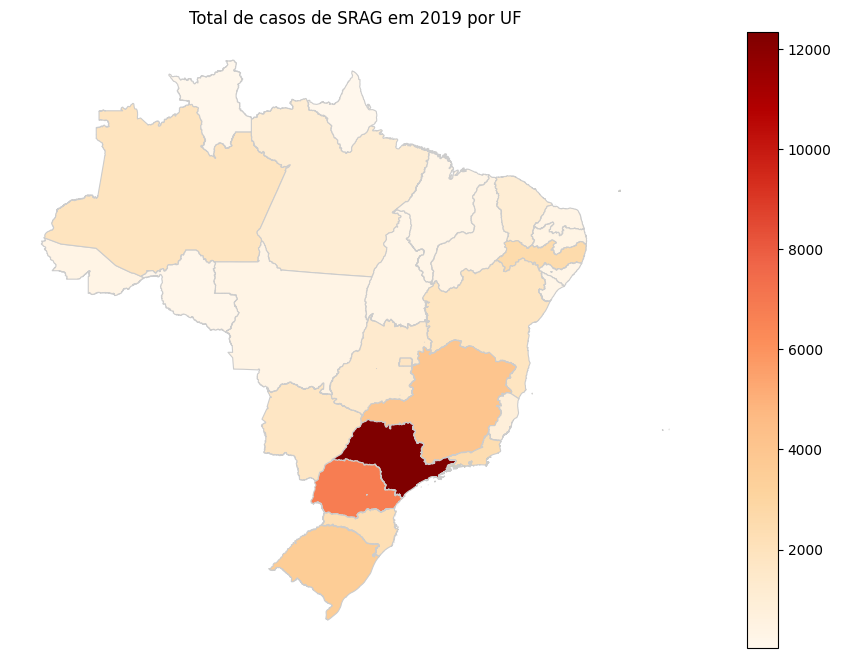

In [5]:
# Mapa coroplético de total de casos por UF
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
geo_cases.plot(column='TOTAL_CASES', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Total de casos de SRAG em 2019 por UF')
ax.axis('off')
plt.show()

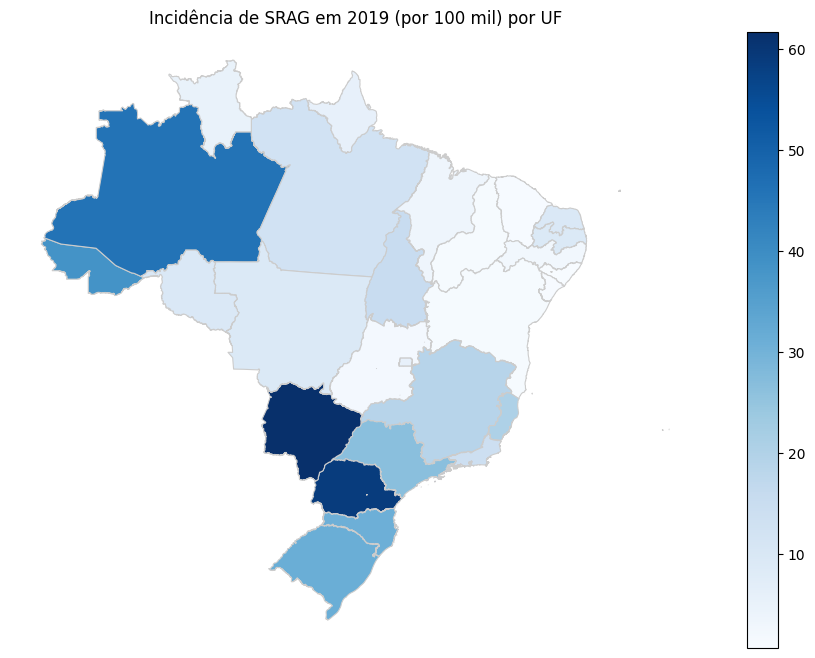

In [6]:
# Mapa coroplético de incidência (casos por 100 mil habitantes) por UF
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
geo_cases.plot(column='Incidencia_100k', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Incidência de SRAG em 2019 (por 100 mil) por UF')
ax.axis('off')
plt.show()

## Conclusão

Os mapas coropléticos revelam padrões geográficos interessantes na distribuição dos casos de SRAG em 2019.
Alguns estados do Norte e Nordeste apresentam incidências relativamente mais altas quando ajustadas pela população,
enquanto grandes centros populacionais como São Paulo e Rio de Janeiro acumulam o maior número absoluto de casos.
Essas visualizações auxiliam na identificação de regiões prioritárias para investigações mais aprofundadas e
intervenções em saúde pública.
